In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
from importlib import reload

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
import Utilities.Sys_unc_variables as Sys_unc
import Utilities.Variables_bins as Variables_bins
from Utilities.ipython_exit import exit

print ('Success')

Welcome to JupyROOT 6.24/06
Success


# Reading in .pkl files

In [2]:
Params = {"Run":"run1", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":"overlay",
          "Load_standard_bkgs":True,
          "Load_DetVars":False,
          "Only_keep_common_DetVar_evs":True,
          "Load_Signal_DetVars":False,
          "Load_data":True,
          "FLATTEN":True, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":False, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "Load_truth_vars":False,
          "Load_lepton_signal":True,
          "Load_pi0_signal":False}

Params, samples = Functions.create_sample_list(Params)
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/"+Params["variables_string"]+"/"

Loading these run1 samples: 
['signal', 'overlay', 'dirtoverlay', 'beamoff', 'beamgood']


In [3]:
samples_dict = {}

for sample in samples:
    if sample in Constants.Detector_variations:
        file = pd.read_pickle(loc_pkls+"DetVars/overlay_"+Params["Run"]+"_"+Params["variables_string"]+f"_{sample}_"+Params["Flat_state"]+"_"+Params["Reduced_state"]+"_final.pkl")
        samples_dict[sample] = file
    if Params["Load_Signal_DetVars"] == True:
        file = pd.read_pickle(loc_pkls+"Signal_DetVars/"+Params["Run"]+f"_{sample}_"+Params["Reduced_state"]+"_final.pkl")
        samples_dict[sample] = file
    else:
        if sample == 'signal':
            for HNL_mass in Constants.HNL_mass_samples:
                file = pd.read_pickle(loc_pkls+f"Preselected_{HNL_mass}_"+Params["Run"]+"_my_vars_flattened_ultimate.pkl")
                # file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
                samples_dict[HNL_mass] = file
        elif sample == 'pi0_signal':
            for HNL_mass in Constants.HNL_mass_pi0_samples:
                file = pd.read_pickle(loc_pkls+f"pi0_selection/Preselected_"+Params["Run"]+f"_{HNL_mass}_pi0.pkl")
                # file = pd.read_pickle(loc_pkls+f"{sample}_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
                samples_dict[str(HNL_mass)+"_pi0"] = file
        elif (Params["Load_single_file"] == True) and (isinstance(sample,int)):
            HNL_mass = sample
            file = pd.read_pickle(loc_pkls+f"signal_{HNL_mass}MeV_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_ultimate.pkl")
            samples_dict[HNL_mass] = file
        else: 
            file = pd.read_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_my_vars_flattened_ultimate.pkl")
            # file = pd.read_pickle(loc_pkls+f"{sample}_"+Params["Run"]+"_"+Params["variables_string"]+"_"+Params["Flat_state"]+"_New_gen.pkl")
            samples_dict[sample] = file

print(samples_dict.keys())

dict_keys([2, 10, 20, 50, 100, 150, 180, 200, 220, 240, 245, 'overlay', 'dirtoverlay', 'beamoff', 'beamgood'])


In [4]:
for sample in samples_dict:
    print(f"{sample} length is " + str(len(samples_dict[sample])))

2 length is 14287
10 length is 12135
20 length is 13414
50 length is 12269
100 length is 12837
150 length is 13585
180 length is 13275
200 length is 12396
220 length is 8971
240 length is 9042
245 length is 9517
overlay length is 44111
dirtoverlay length is 6745
beamoff length is 6384
beamgood length is 7662


# Make plotting dictionaries

In [5]:
#Want to have arrows drawn on for where the preselection cut goes
HNL_mass = 100
if Params["Load_pi0_signal"]:
    HNL_mass = f"{HNL_mass}_pi0" #only plotting one at a time

samples_plotting = {"overlay":samples_dict["overlay"],
                    "dirtoverlay":samples_dict["dirtoverlay"],
                    "beamoff":samples_dict["beamoff"],
                    "signal":samples_dict[HNL_mass]}

if Params["Run"] == "run1":
    sample_norms = {"overlay":Constants.SF_overlay_run1,
                    "dirtoverlay":Constants.SF_dirt_run1,
                    "beamoff":Constants.SF_EXT_run1,
                    "signal":Constants.run1_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run1_Sys_unc
elif Params["Run"] == "run3":
    sample_norms = {"overlay":Constants.SF_overlay_run3,
                    "dirtoverlay":Constants.SF_dirt_run3,
                    "beamoff":Constants.SF_EXT_run3,
                    "signal":Constants.run3_POT_scaling_dict[HNL_mass]}
    flat_sys_vars_dict = Sys_unc.run3_Sys_unc

if Params["Load_data"] == True:
    data_dict = {"beamgood":samples_dict["beamgood"]}
    data_norm = {"beamgood":1.0} #No scaling as this is data, should have scaled MC to this POT.
    samples_plotting.update(data_dict)
    sample_norms.update(data_norm)
    
PT.HNL_scaling_calculator(samples_plotting,sample_norms)


The ratio of overlay to HNL events is 3527394

The ratio of all bkgs to HNL events is 7556263



## Plot data

In [6]:
New_feature_list = ['shrclusdir2', 'n_tracks', 'trk_energy', 'shr_theta_v', 'contained_sps_ratio', 'trk_chipr_best', 'shr_px_v',
                    'trk_end_x_v', 'n_pfps', 'pfnplanehits_V', 'pfnplanehits_U', 'trk_calo_energy_u_v', 'nu_flashmatch_score', 'trk_score_v',
                    'NeutrinoEnergy2', 'shr_phi_v', 'pfnplanehits_Y', 'shr_pz_v', 'trk_theta_v', 'trk_phi_v', 'trk_energy_hits_tot',
                    'trk_dir_z_v', 'SliceCaloEnergy2']
var_list_save = ['shrclusdir2', 'n_tracks', 'trk_energy',
       'shr_theta_v', 'contained_sps_ratio', 'trk_chipr_best', 'shr_px_v',
       'trk_end_x_v', 'n_pfps', 'pfnplanehits_V', 'pfnplanehits_U',
       'trk_calo_energy_u_v', 'nu_flashmatch_score', 'trk_score_v',
       'NeutrinoEnergy2', 'shr_phi_v', 'pfnplanehits_Y', 'shr_pz_v',
       'trk_theta_v', 'trk_phi_v', 'trk_energy_hits_tot', 'trk_dir_z_v',
       'SliceCaloEnergy2', 'trk_score', 'shr_energy_tot', 'trk_energy_tot', 'n_showers']
count = 0

In [43]:
#Calculate sys
# variable = var_list_save[count]
# count+=1

Calculate_sys = True
variable = 'trk_theta_v'


print("\'"+variable+"\'")

reload(PT)
reload(Functions)
reload(Constants)
reload(Sys_unc)
reload(Variables_bins)

if Params["Run"] == "run1": flat_sys_vars_dict = Sys_unc.run1_Sys_unc
if Params["Run"] == "run3": flat_sys_vars_dict = Sys_unc.run3_Sys_unc

print("Maximum value in overlay is " + str(max(samples_plotting["overlay"][variable].to_numpy())))    
print("Maximum value in signal is " + str(max(samples_plotting["signal"][variable].to_numpy()))) 
print("Manimum value in signal is " + str(min(samples_plotting["signal"][variable].to_numpy()))) 
samples_plotting.keys()

'trk_theta_v'
Maximum value in overlay is 3.1242428
Maximum value in signal is 3.1286058
Manimum value in signal is -9999.0


dict_keys(['overlay', 'dirtoverlay', 'beamoff', 'signal', 'beamgood'])

Plotting trk_theta_v for run1
[0.   0.16 0.32 0.48 0.64 0.8  0.96 1.12 1.28 1.44 1.6  1.76 1.92 2.08
 2.24 2.4  2.56 2.72 2.88 3.04 3.2 ]
[0.0, 3.2]


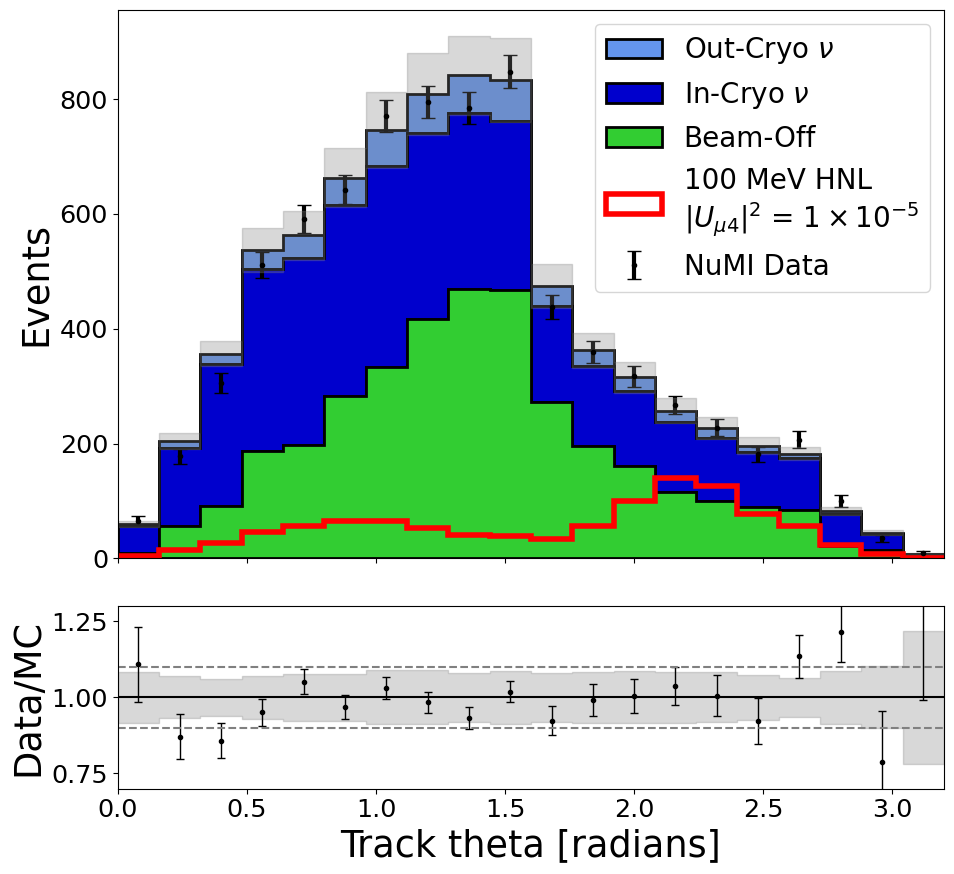

In [45]:
savefig = False

print(f"Plotting {variable} for " + Params["Run"])

xlabel = Constants.variable_names_dict[variable]

bins = Variables_bins.BDT_vars_bins[variable]
xlims = [bins[0],bins[-1]]
print(bins)
print(xlims)
# PT.Plot_preselection_variable_data(variable, samples_plotting, sample_norms, xlabel="Neutrino slice",xlims=[-0.5,1.5],bins=2, HNL_mass=HNL_mass,
#                               HNLplotscale=80000000,cutline=0.0,legloc="upper right", show_ev_nums=False, CalcSys=Calculate_sys, xticks = [0,1])
PT.Plot_preselection_variable_data(variable, samples_plotting, sample_norms, xlabel=xlabel, xlims=xlims, bins=bins, HNL_mass=HNL_mass,
                                   HNLplotscale=1000000,cutline=0.0,legloc="best", show_ev_nums=False, CalcSys=Calculate_sys, xticks = [], 
                                   sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylimit=None, legsize=20, logy=False,
                                   HNL_scale_label=True)

# if variable == "n_pfps":plt.xlim([0.5, 8.5])

# plt.axvline(x=16.5, lw=3, color='green', linestyle = 'dashed')
Name = "Labelled_"
if Params["Load_pi0_signal"] == True: Name = "pi0/"
if Calculate_sys==True: Sys_name = "with_sys"
if Calculate_sys==False: Sys_name = "no_sys"

if savefig == True:
    plt.savefig(f"plots/Data_MC_comparison/BDT_input_variables/{Name}{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}.png")
    plt.savefig(f"plots/Data_MC_comparison/BDT_input_variables/{Name}{variable}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}.pdf")

## Make all BDT input plots (broken? don't know why)

In [ ]:
np.seterr(divide='ignore', invalid='ignore') # to stop annoying output about dividing by zeros or Nans
vars_to_plot = ['shrclusdir2', 'n_tracks', 'trk_energy', 'shr_theta_v', 'contained_sps_ratio', 'trk_chipr_best', 'shr_px_v',
                'trk_end_x_v', 'n_pfps', 'pfnplanehits_V', 'pfnplanehits_U', 'trk_calo_energy_u_v', 'nu_flashmatch_score', 'trk_score_v',
                'NeutrinoEnergy2', 'shr_phi_v', 'pfnplanehits_Y', 'shr_pz_v', 'trk_theta_v', 'trk_phi_v', 'trk_energy_hits_tot',
                'trk_dir_z_v', 'SliceCaloEnergy2', 'trk_energy_tot', 'shr_energy_tot', 'trk_calo_energy_u_v', 'trk_score_v', 'n_showers']

Calculate_sys = True
Name = ""
if Params["Load_pi0_signal"] == True: Name = "pi0/"
loc = f"plots/Data_MC_comparison/BDT_input_variables/"
if Calculate_sys==True: Sys_name = "with_sys"
#Need to add in savefig and savename in argument of plotting function, also make name better.
for var in vars_to_plot:
    print(var)
    savename = f"{Name}{var}_" + Params["Run"] + f"_{HNL_mass}MeV_{Sys_name}"
    xlabel = Constants.variable_names_dict[var]
    full_bins = Variables_bins.bins_var[var]
    bins = len(full_bins)-1
    xlims = [full_bins[0],full_bins[-1]]
    print(full_bins)
    PT.Plot_preselection_variable_data(variable, samples_plotting, sample_norms, xlabel=xlabel, xlims=xlims, bins=bins, HNL_mass=HNL_mass,
                                       HNLplotscale=2000000,cutline=0.0,legloc="best", show_ev_nums=False, CalcSys=Calculate_sys, xticks = [], 
                                       sys_dict=flat_sys_vars_dict, centre_bins=False, hatch=False, ylimit=None, legsize=22, logy=False, display=False,
                                       savefig=False, savename=loc+savename)
    

## Plotting just signal

In [ ]:
plt.figure(figsize=[10,10])

for HNL_mass in Constants.HNL_mass_samples:
    plt.plot(np.array(range(1, len(Efficiency_dict[effic])+1)),Efficiency_dict[HNL_mass],label=f"{HNL_mass} MeV HNL",lw=4,markersize=15)
    
plt.ylabel("Fraction Selected")
plt.xticks(np.array(range(1, len(Efficiency_dict[effic])+1)),["Full sample"]+list(Preselection_dict.keys()),rotation=80)
# plt.yscale("log")
plt.legend()

plt.savefig("plots/Preselection_efficiencies/Signal_only_"+Params["Run"]+"_"+Params["Flat_state"]+".png")

# End of code